# Fit bambi model to females

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
)
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig2-test", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [4]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    # pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_mouse_area_df_v00.parquet'
    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]
    return df, sizes_col

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [6]:
df, sizes_col = read_female_ontogeny(keep_syllables)

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

# label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
# sex_id = label_encoder.fit_transform(
#     np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
# ).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

# df['sex'] = np.where(sex_id == 1)[0]
# df = df.set_index('sex', append=True)

In [24]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
    # "mice": sex_id,
}

age_sd = 0.045
# age_sd = 10

hypparams = {
    "log_age": True,
    # "log_age": False,
    "min_age": 1,
    "max_age": 130,
    "age_sd": age_sd,
    "n_age_samples": 1500,
    "n_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 175,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    # "n_animals": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 250,
}

### Optimize Age SD

In [8]:
keep_keys = ['heldout_ll', 'heldout_r2_total', 'heldout_r2_total_v3', 'true_ages', 'bio_ages']

In [9]:
outs = []

for age_sd in tqdm(np.logspace(-2, 0, 11)):
    hypparams["age_sd"] = float(age_sd)

    tmp = masked_xval(features, hypparams, 5, n_repeats=4, disable_tqdm=True)
    tmp = valmap(lambda v: keyfilter(lambda k: k in keep_keys, v), tmp)
    for k, v in tmp.items():
        outs.append({
            "repeat": k,
            "age_sd": age_sd,
            **v
        })
outs_df = pd.DataFrame(outs)

  0%|          | 0/21 [00:00<?, ?it/s]

In [10]:
optimal_age_sd = outs_df.groupby('age_sd')['heldout_ll'].mean().idxmax()
optimal_age_sd

0.09999999999999999

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


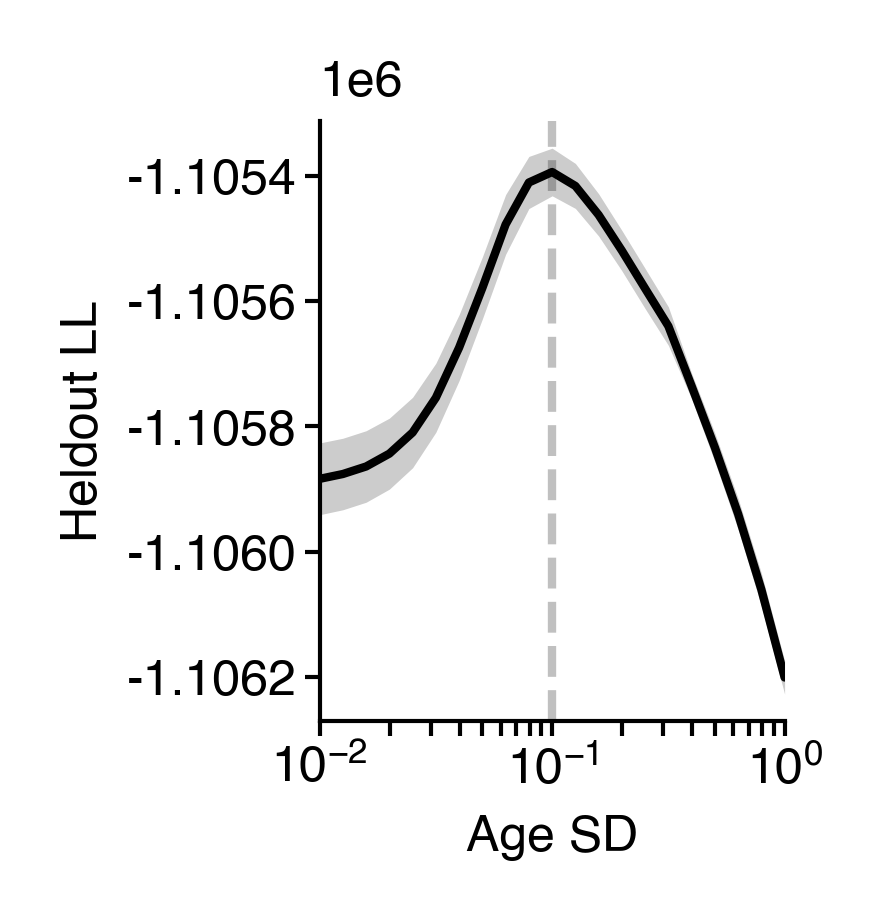

In [11]:
fig = figure(1, 1.3)
ax = sns.lineplot(
    data=outs_df,
    x="age_sd",
    y="heldout_ll",
    errorbar="se",
    err_kws=dict(lw=0),
    color="k",
)
ax.set(ylabel="Heldout LL", xlabel="Age SD", xscale='log', xlim=(1e-2, 1))
ax.axvline(optimal_age_sd, ls='--', color='silver', zorder=-1)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-age-sd-optimization");

In [41]:
# hypparams['age_sd'] = 0.1
# combined_results = masked_xval(features, hypparams, 5, n_repeats=25)

# bio_age_samples = [pd.Series(v['bio_ages'], index=df.index) for v in combined_results.values()]
# bio_age_samples = pd.DataFrame(bio_age_samples).T
# bio_age_samples.to_parquet('/n/scratch/users/w/wg41/bio-age-model/combined-results-ontogeny-sex-predictions-2024-05-15.parquet')

# combined_r2s = list(pluck('heldout_r2_total_v3', combined_results.values()))

## Show shuffles/controls

In [17]:
# optimal_age_sd = 0.1

In [8]:
n_repeats = 10

In [9]:
# hypparams['age_sd'] = float(optimal_age_sd)

mdl0 = masked_xval(features, hypparams, 0, n_repeats=n_repeats)
r2_0 = list(pluck('heldout_r2_total_v3', mdl0.values()))
print(np.mean(r2_0))
del mdl0

mdl1 = masked_xval(features, hypparams, 1, n_repeats=n_repeats)
r2_1 = list(pluck('heldout_r2_total_v3', mdl1.values()))
print(np.mean(r2_1))
del mdl1

mdl2 = masked_xval(features, hypparams, 2, n_repeats=n_repeats)
r2_2 = list(pluck('heldout_r2_total_v3', mdl2.values()))
print(np.mean(r2_2))
del mdl2

mdl3 = masked_xval(features, hypparams, 5, n_repeats=n_repeats)
r2_3 = list(pluck('heldout_r2_total_v3', mdl3.values()))
print(np.mean(r2_3))
del mdl3

hypparams['age_sd'] = 1e-6
mdl0_1 = masked_xval(features, hypparams, 1, n_repeats=n_repeats)
r2_0_1 = list(pluck('heldout_r2_total_v3', mdl0_1.values()))
print(np.mean(r2_0_1))
del mdl0_1

  0%|          | 0/10 [00:00<?, ?it/s]

0.4195777062619701


  0%|          | 0/10 [00:00<?, ?it/s]

0.4796724149332534


  0%|          | 0/10 [00:00<?, ?it/s]

0.4952960502817995


  0%|          | 0/10 [00:00<?, ?it/s]

0.5453731935781094


  0%|          | 0/10 [00:00<?, ?it/s]

0.08488669676058488


In [10]:
# shuffle syllables
np.random.seed(0)
shuff_features = deepcopy(features)
# hypparams['age_sd'] = float(optimal_age_sd)
hypparams['age_sd'] = age_sd

r2_shuff = []
for i in tqdm(range(n_repeats)):
    perm = np.array([np.random.permutation(58) for _ in range(len(syllable_counts_jax))])
    shuff = syllable_counts_jax[np.arange(len(syllable_counts_jax))[:, None], perm]
    shuff_features['counts'] = shuff
    try:
        tmp = masked_xval(shuff_features, hypparams, model_version=5, n_repeats=1, disable_tqdm=True)
        r2_shuff.append(tmp[0]['heldout_r2_total_v3'])
    except ValueError:
        continue
print(np.mean(r2_shuff))

  0%|          | 0/10 [00:00<?, ?it/s]

-0.008427479767827869


In [11]:
# shuffle ages
# np.random.seed(0)
# shuff_ages = deepcopy(features)
# hypparams['age_sd'] = float(optimal_age_sd)

# r2_age_shuff = []
# for i in tqdm(range(n_repeats)):
#     shuff = np.random.permutation(len(features['ages']))
#     shuff_ages['ages'] = features['ages'][shuff]
#     tmp = masked_xval(shuff_ages, hypparams, model_version=5, n_repeats=1, disable_tqdm=True, seed=i)
#     r2_age_shuff.append(tmp[0]['heldout_r2_total_v3'])

In [12]:
# shuffle sexes
np.random.seed(0)

shuff_features = deepcopy(features)

shuff_r2s = []
for i in tqdm(range(n_repeats)):
    shuff_features['mice'] = np.random.permutation(features['mice'].T).T
    shuff_results = masked_xval(shuff_features, hypparams, 5, n_repeats=1, disable_tqdm=True, seed=i)
    shuff_r2s.append(shuff_results[0]['heldout_r2_total_v3'])
print(np.mean(shuff_r2s))

  0%|          | 0/10 [00:00<?, ?it/s]

0.4983324129813533


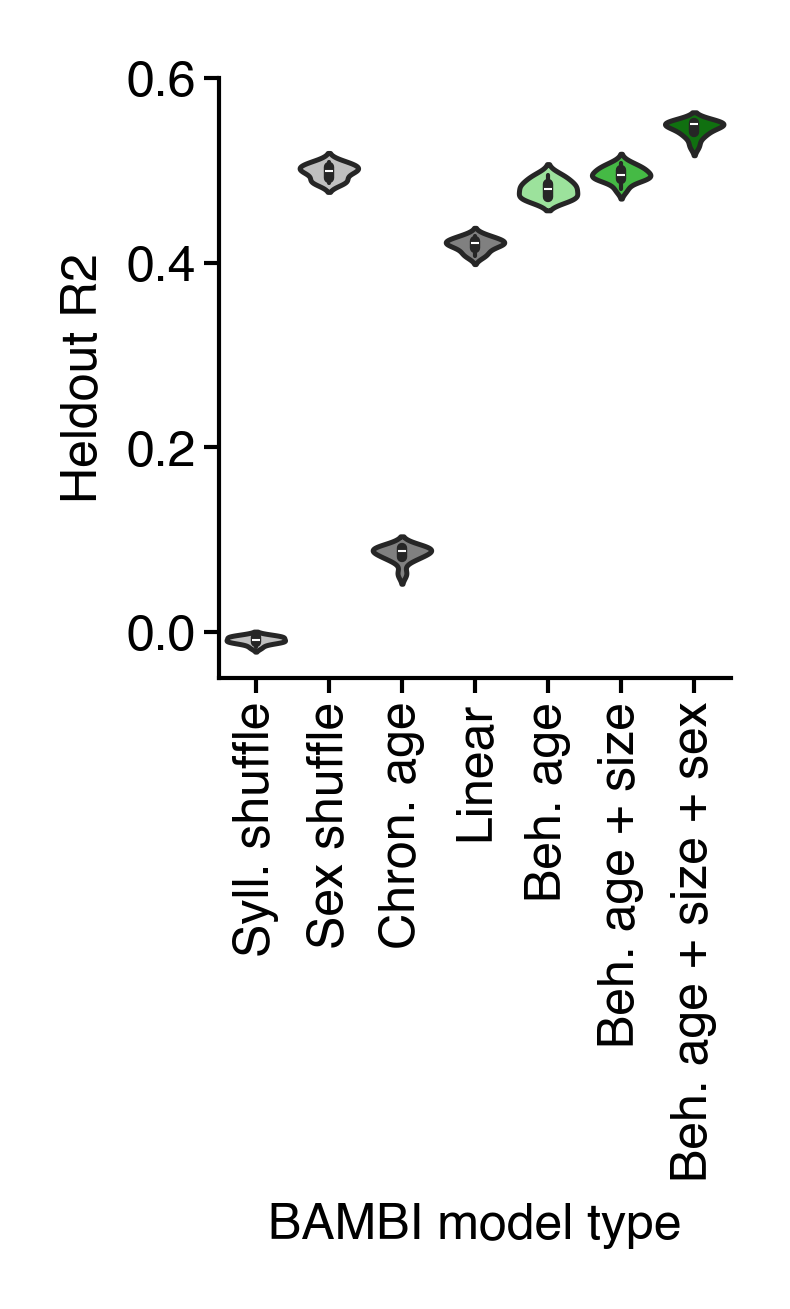

In [70]:
plt_data = {
    "Syll. shuffle": r2_shuff,
    # "Age shuffle": r2_age_shuff,
    "Sex shuffle": shuff_r2s,
    "Chron. age": r2_0_1,
    "Linear": r2_0,
    "Beh. age": r2_1,
    "Beh. age + size": r2_2,
    "Beh. age + size + sex": r2_3,
}

fig = figure(1.1, 1.3)
ax = sns.violinplot(
    data=plt_data,
    # palette=["silver", "silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    palette=["silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    width=0.8, linewidth=0.6,
    inner_kws=dict(box_width=1.25, whis_width=0.5),
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout R2",
    ylim=(-0.05, 0.6),
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-r2-model-comparison");

## Get males vs females

In [14]:
# hypparams['age_sd'] = float(optimal_age_sd)

In [62]:
hypparams['log_age'] = False
hypparams['age_sd'] = 10

In [25]:
mdl = fit_model(features, hypparams, 2)

## Create extra dataframes for dana

In [26]:
def read_female_ontogeny2(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]
    return df, sizes_col

df_copy, sizes_col = read_female_ontogeny2(keep_syllables)
df_copy['beh_age'] = mdl['bio_ages']

# !mkdir /n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df

_ages = df_copy.index.get_level_values('age')
df_copy = df_copy.sort_values(by='beh_age')
df_copy['new_age'] = _ages

In [27]:
df_copy = df_copy.sort_index(level='age')

In [28]:
from sklearn.decomposition import PCA

In [29]:
def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [30]:
scores = PCA(n_components=2).fit_transform(minmax(df_copy.drop(columns=['new_age', 'beh_age'])))

In [31]:
scores_df = pd.DataFrame(scores, index=df_copy.index)

In [32]:
scores_df['new_age'] = df_copy['new_age']

In [33]:
rho = scores_df.corr(method='spearman').loc[0, 'new_age']
rho

-0.3970309816855339

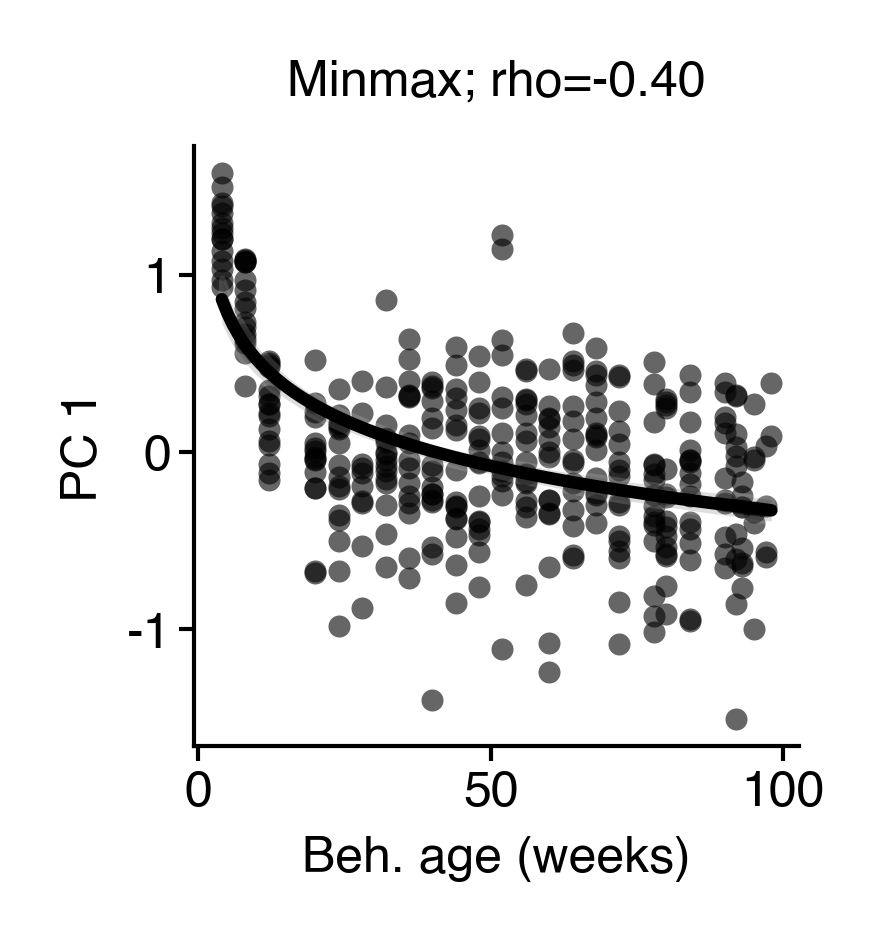

In [34]:
figure(1.3, 1.3)
ax = sns.regplot(x=scores_df['new_age'], y=scores_df[0], logx=True, color='k', scatter_kws=dict(linewidths=0, alpha=0.6, s=7))
ax.set(ylabel="PC 1", xlabel="Beh. age (weeks)", title=f"Minmax; rho={rho:0.2f}")
sns.despine()

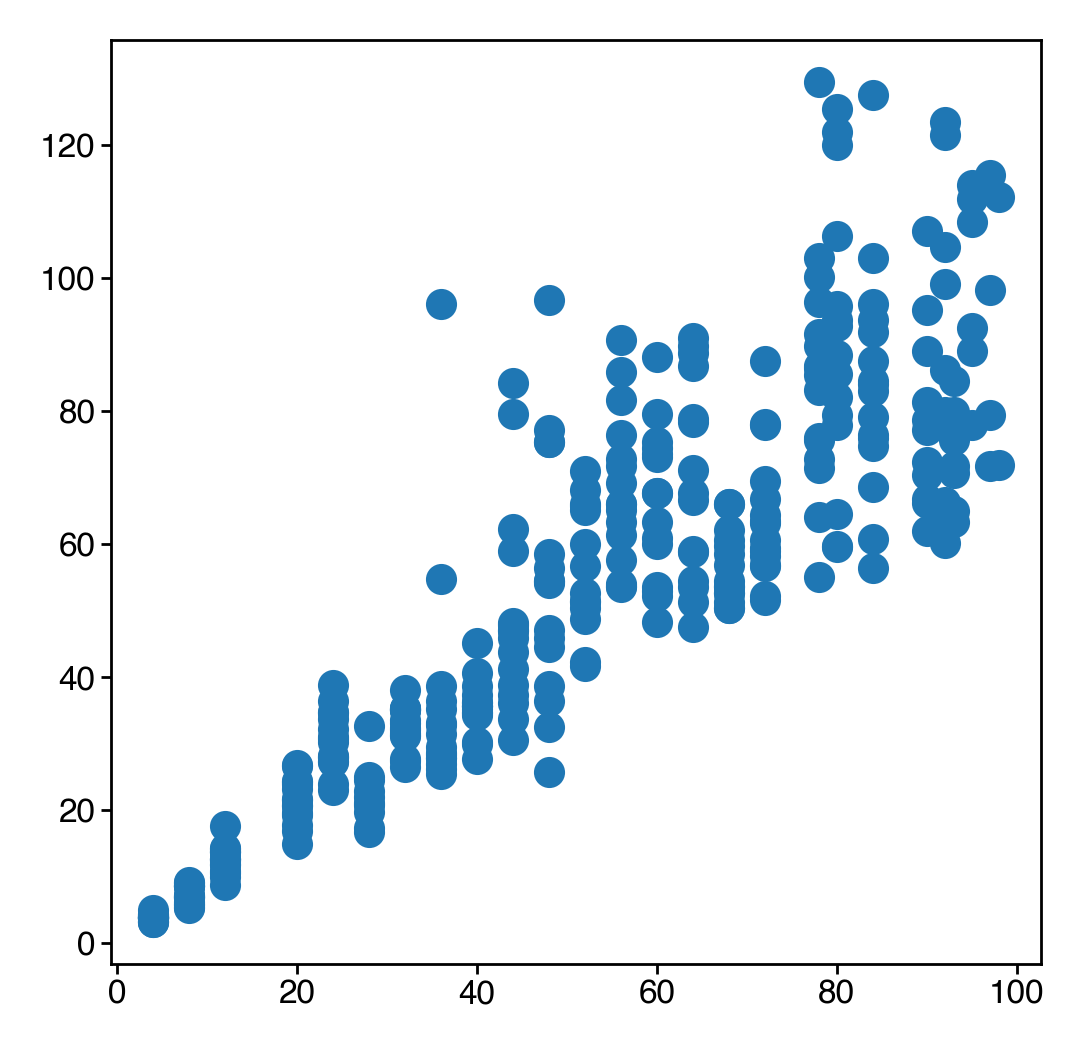

In [40]:
plt.scatter(mdl['true_ages'], mdl['bio_ages'])

In [35]:
scores = PCA(n_components=2).fit_transform(df_copy.drop(columns=['new_age', 'beh_age']))

In [36]:
scores_df = pd.DataFrame(scores, index=df_copy.index)

In [37]:
scores_df['new_age'] = df_copy['new_age']

In [38]:
rho = scores_df.corr(method='spearman').loc[0, 'new_age']
rho

0.3142276173686506

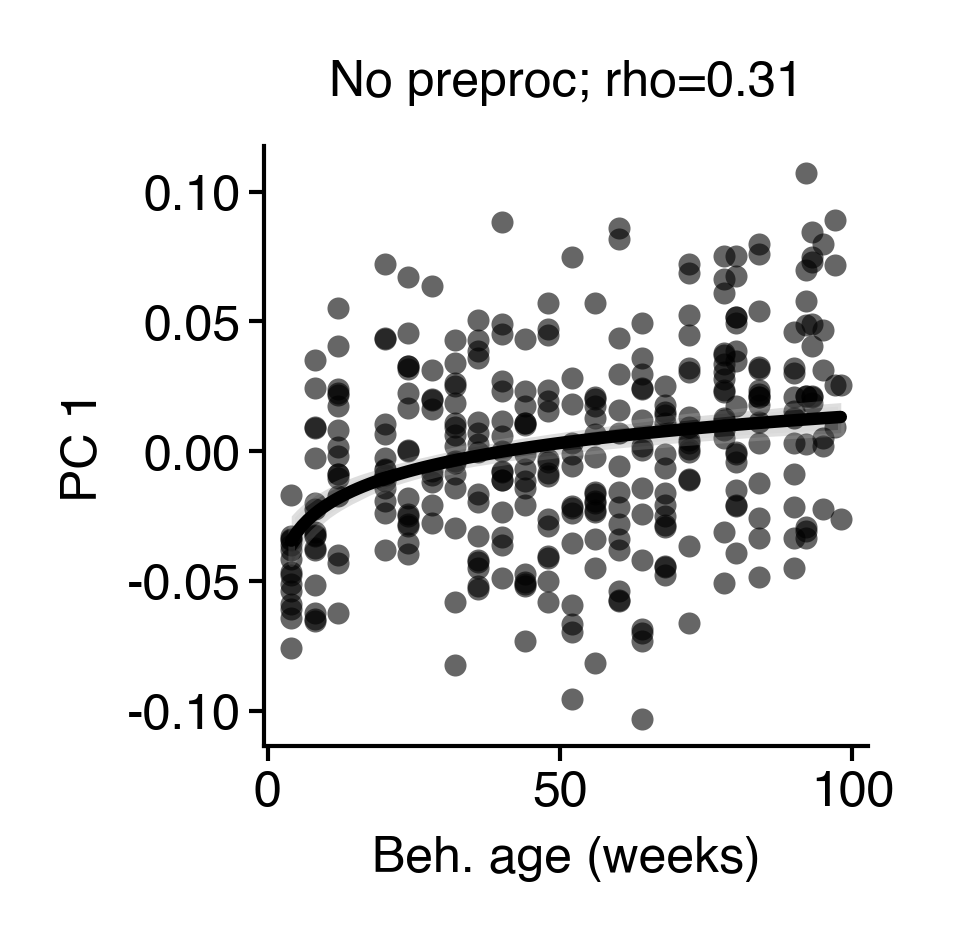

In [39]:
figure(1.3, 1.3)
ax = sns.regplot(x=scores_df['new_age'], y=scores_df[0], logx=True, color='k', scatter_kws=dict(linewidths=0, alpha=0.6, s=7))
ax.set(ylabel="PC 1", xlabel="Beh. age (weeks)", title=f"No preproc; rho={rho:0.2f}")
sns.despine()

## Plots and analysis

In [9]:
labels = LabelEncoder().fit_transform(np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))]))

In [ ]:
# male is blue, female is orange
example_mice = [0, 1]

mask = []
for m in example_mice:
    mask.append(labels == m)
mask = reduce(or_, mask)

sylls = [0, 1, 3, 5, 6, 8, 10, 14, 15, 19, 23]
fig, ax = plt.subplots(len(sylls), 3, figsize=(3, len(sylls)), sharex=True)

true_age = mdl["true_ages"][mask]
bio_age = mdl["bio_ages"][mask]
counts = mdl["counts"][mask]
pred_counts = mdl["predicted_counts"][mask]

pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)

for a, syll, i in zip(ax, map(lambda i: sort_idx[i], sylls), sylls):
    max_counts = max([counts[:, syll].max(), pred_counts[:, syll].max()]) * 1.05
    a[0].scatter(true_age, counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0)
    a[0].set(title=f"Idx {i} Syllable {syll}", ylabel="Counts", xlabel="Chron. age (weeks)", ylim=(0, max_counts))

    a[2].scatter(bio_age, pred_counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0)
    a[2].set(ylabel="Pred. counts", xlabel="Beh. age (weeks)", ylim=(0, max_counts), yticklabels=[])

    a[1].scatter(bio_age, counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0)
    a[1].set(ylabel="Counts", xlabel="Beh. age (weeks)", ylim=(0, max_counts), yticklabels=[])

sns.despine()
fig.tight_layout()

saver(fig, "sex-ontogeny-true-vs-predicted-counts");

In [11]:
list(mdl['params'])

['bio_basis_weights', 'development_weights', 'individual_biases', 'size_slope']

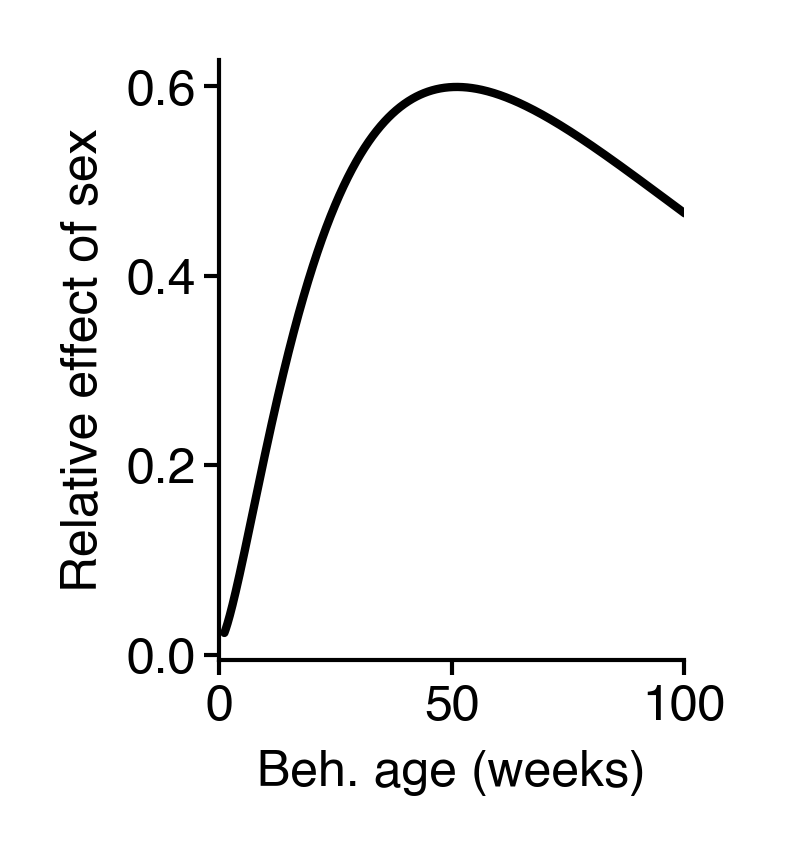

In [12]:
x = mdl['params']['development_weights']
dev = (x @ mdl['init_components'].bases['development']).squeeze()

comps = mdl['init_components']

dev = np.exp(dev)

# height 1.3
fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of sex")
sns.despine()
saver(fig, "ontogeny-effect-of-sex");

## Make ontogeny sex age plot

In [13]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = sns.lineplot(
        data=age_df,
        x="true_ages",
        y="bio_ages",
        hue="labels",
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        legend=False,
        zorder=-1,
        lw=0.25,
        err_kws=dict(lw=0),
    )
    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (weeks)",
        ylabel="Behavioral age (weeks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

In [14]:
age_df = pd.DataFrame(
    dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=labels),
)

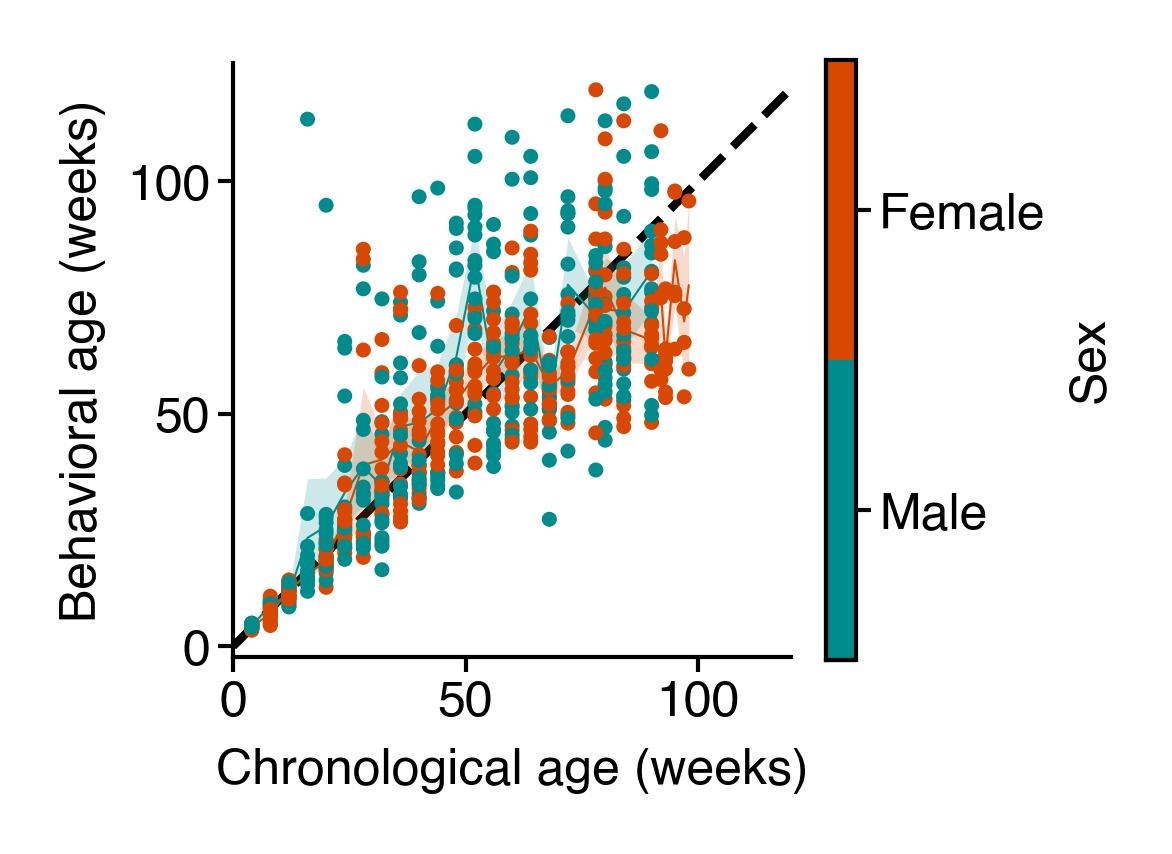

In [15]:
fig = make_plot(age_df, 1.5, 1.3)
saver(fig, "ontogeny-sex-chron-vs-beh-age-all-timepoints");

## Sorting by model predictions

In [16]:
df_copy = df.copy().astype('float32')

# normalize to sum to 1
df_copy = df_copy / (df_copy.sum(1).to_numpy()[:, None])
df_copy['beh_age'] = mdl['bio_ages']
df_copy = df_copy.set_index('beh_age', append=True)

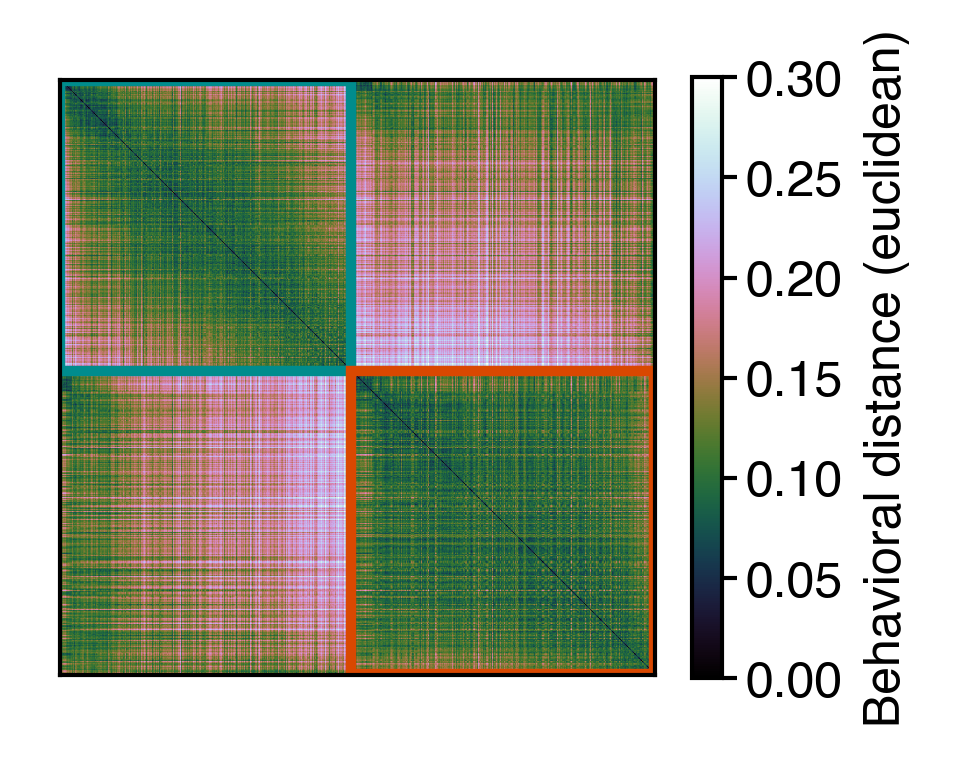

In [17]:
d = pdist(df_copy.sort_index(level=["sex", "beh_age"]), metric="euclidean")
d = squareform(d)

fig = figure(1.6, 1.3)
ax = fig.gca()
im = ax.imshow(d, cmap="cubehelix", vmax=0.3)
fig.colorbar(im, ax=ax, label="Behavioral distance (euclidean)")

start = len(df) - len(female_df) - 1
patch = plt.Rectangle(
    (0, 0),
    start,
    start,
    edgecolor=COLORMAPS.ont_male(255),
    facecolor="none",
    linewidth=1.25,
)
ax.add_patch(patch)
patch = plt.Rectangle(
    (start, start),
    len(female_df) - 1,
    len(female_df) - 1,
    edgecolor=COLORMAPS.ont_female(255),
    facecolor="none",
    linewidth=1.25,
)
ax.add_patch(patch)
ax.set(xticks=[], yticks=[])
saver(fig, 'male-female-sorted-distance-matrix');

## PCA on model predictions

In [18]:
from sklearn.decomposition import PCA

In [19]:
list(mdl)

['params',
 'heldout_ll',
 'loss',
 'bio_ages',
 'age_likelihoods',
 'true_ages',
 'init_components',
 'concentrations',
 'concentration_components',
 'predicted_counts',
 'counts',
 'r2_total',
 'r2_each']

In [20]:
mdl['predicted_counts'].shape

(680, 58)

In [21]:
pc = mdl['predicted_counts']
pc = pc / pc.sum(1, keepdims=True)

In [22]:
pca = PCA(n_components=2)
scores = pca.fit_transform(pc)
scores_df = pd.DataFrame(scores, index=df.index)
# scores_df['sex'] = labels

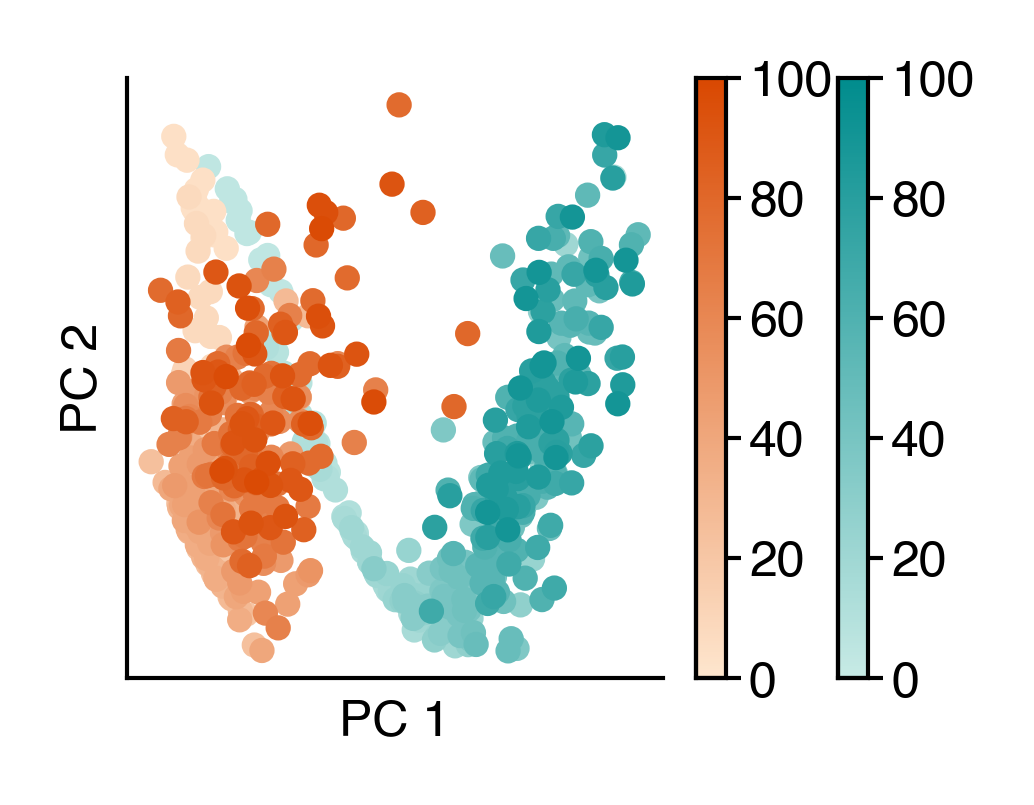

In [23]:
fig = figure(1.8, 1.3)
ax = fig.gca()
for sex, _df in scores_df.groupby('sex'):
    cm = COLORMAPS.ont_male if sex == 0 else COLORMAPS.ont_female
    im = ax.scatter(_df[0], _df[1], c=_df.index.get_level_values('age'), cmap=cm, s=5, vmax=100, vmin=0)
    cb = fig.colorbar(im, ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, "model-based-pca-males-females");

In [24]:
scores_df['bio_age'] = mdl['bio_ages']

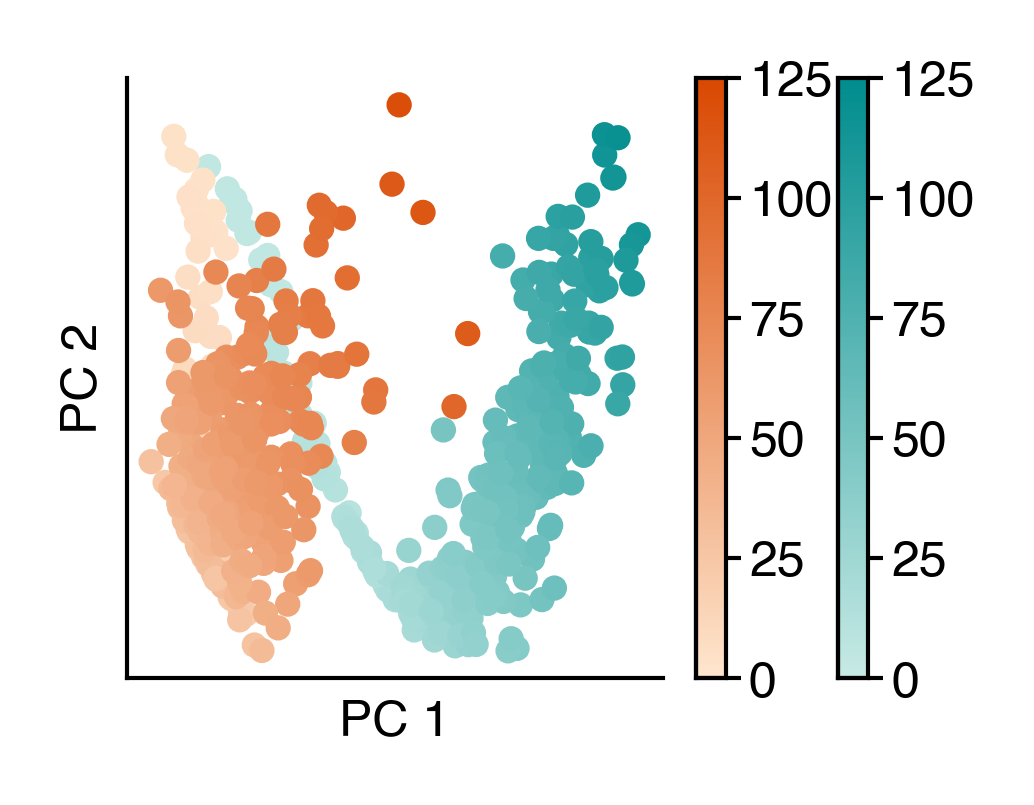

In [25]:
fig = figure(1.8, 1.3)
ax = fig.gca()
for sex, _df in scores_df.groupby('sex'):
    cm = COLORMAPS.ont_male if sex == 0 else COLORMAPS.ont_female
    im = ax.scatter(_df[0], _df[1], c=_df['bio_age'], cmap=cm, s=5, vmin=0, vmax=125)
    cb = fig.colorbar(im, ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, "model-based-pca-males-females-bio-age");

## Plot age likelihoods

In [26]:
list(mdl)

['params',
 'heldout_ll',
 'loss',
 'bio_ages',
 'age_likelihoods',
 'true_ages',
 'init_components',
 'concentrations',
 'concentration_components',
 'predicted_counts',
 'counts',
 'r2_total',
 'r2_each']

In [27]:
_age = mdl['init_components'].age_unnormalizer(mdl['init_components'].age_samples)

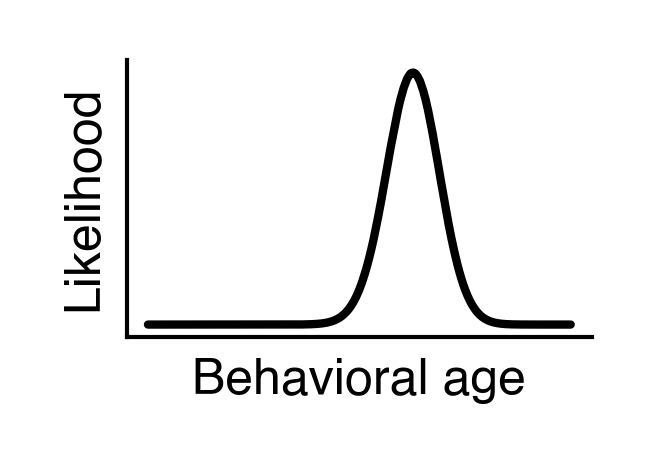

In [28]:
fig = figure(1, 0.6)
ax = fig.gca()
ax.plot(_age, mdl['age_likelihoods'][100], color='k')
ax.set(xticks=[], yticks=[], xlabel="Behavioral age", ylabel="Likelihood")
sns.despine()
saver(fig, "beh-age-likelihood-function-schematic");

In [29]:
from scipy.stats import norm

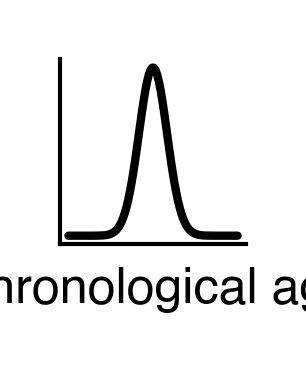

In [30]:
out = norm.pdf(np.linspace(-6, 6, 100), loc=0, scale=1)

fig = figure(0.4, 0.4)
ax = fig.gca()
ax.plot(out, color='k')
ax.set(xticks=[], yticks=[], xlabel="Chronological age")
sns.despine()
saver(fig, "chron-age-prior-schematic");

## Relative contributions

In [31]:
conc_c = mdl['concentration_components']
indiv_components = conc_c['indiv'] * conc_c['indiv_scale'][None, :, None]

total = (
    np.abs(conc_c["bio"][..., None])
    + np.abs(indiv_components)
    + np.abs(conc_c["size"][:, None, :])
)

In [32]:
inds = np.argmax(mdl['age_likelihoods'], axis=1)

In [33]:
bio = np.abs(conc_c['bio'][..., None]) / total
indiv = np.abs(indiv_components) / total
size = np.abs(conc_c['size'][:, None, :]) / total

In [34]:
bio = bio[:, inds, np.arange(len(inds))]
indiv = indiv[:, inds, np.arange(len(inds))]
size = size[:, inds, np.arange(len(inds))]

In [35]:
bio_df = pd.DataFrame(bio.T, index=df.index).reset_index()
bio_df["bio_age"] = mdl["bio_ages"]
bio_df = bio_df.drop(columns=['subject_name', 'session_name', 'uuid', 'date']).melt(
    id_vars=["mouse", "age", "bio_age", "sex"], var_name="syllable", value_name="influence"
)
bio_df["type"] = "Beh. age"

size_df = pd.DataFrame(size.T, index=df.index).reset_index()
size_df["bio_age"] = mdl["bio_ages"]
size_df = size_df.drop(columns=['subject_name', 'session_name', 'uuid', 'date']).melt(
    id_vars=["mouse", "age", "bio_age", "sex"], var_name="syllable", value_name="influence"
)
size_df["type"] = "Size"

indiv_df = pd.DataFrame(indiv.T, index=df.index).reset_index()
indiv_df["bio_age"] = mdl["bio_ages"]
indiv_df = indiv_df.drop(columns=['subject_name', 'session_name', 'uuid', 'date']).melt(
    id_vars=["mouse", "age", "bio_age", "sex"], var_name="syllable", value_name="influence"
)
indiv_df["type"] = "Sex"

In [36]:
plt_dfs = pd.concat([bio_df, size_df, indiv_df])
plt_dfs['bio_bin'] = pd.cut(plt_dfs['bio_age'], 35)
plt_dfs['bio_bin'] = plt_dfs['bio_bin'].map(lambda x: x.mid)
plt_dfs['age_bin'] = pd.cut(plt_dfs['age'], 35)
plt_dfs['age_bin'] = plt_dfs['age_bin'].map(lambda x: x.mid)

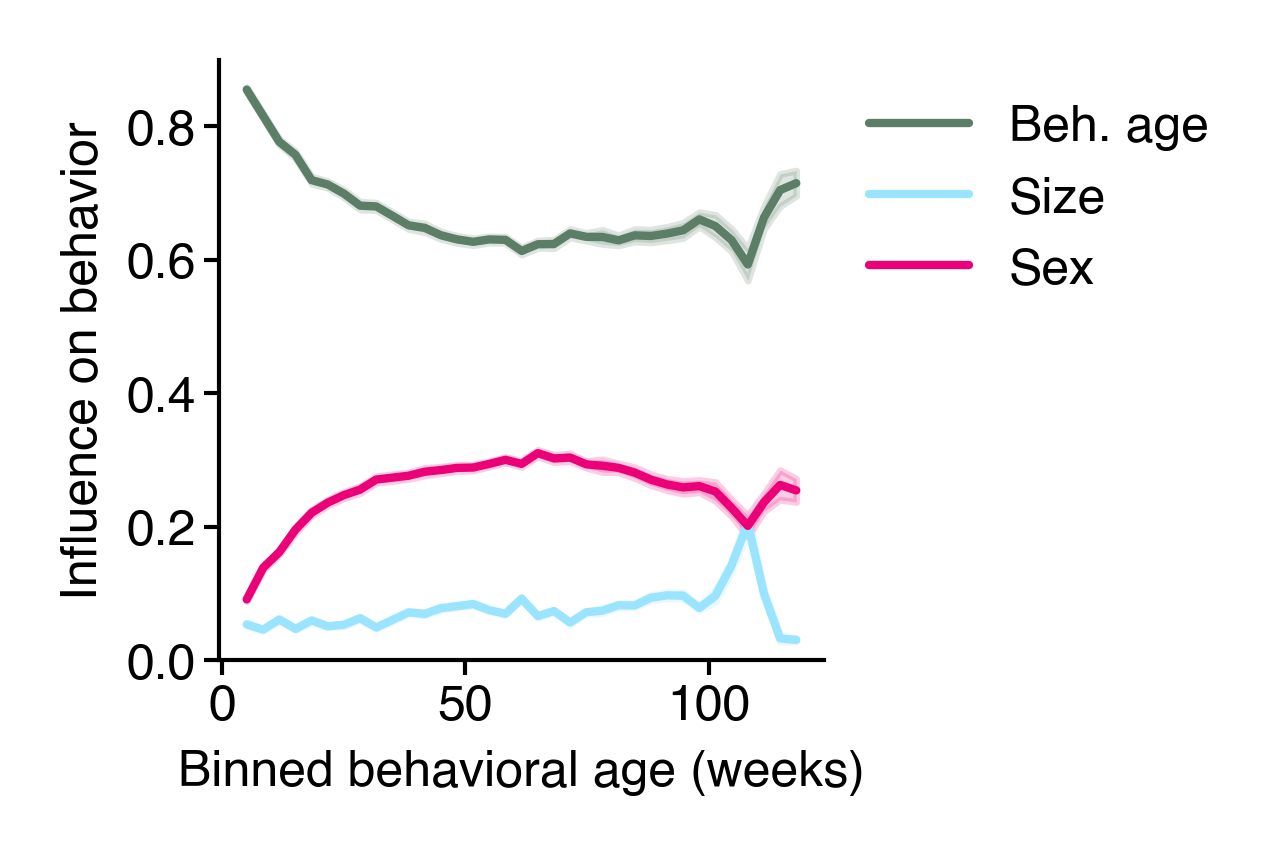

In [37]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(data=plt_dfs, x='bio_bin', y='influence', errorbar='se', hue='type', palette=cc.glasbey[24:27])
ax.set(xlabel="Binned behavioral age (weeks)", ylabel="Influence on behavior", ylim=(0, 0.9))
legend()
sns.despine()
saver(fig, 'sex-component-influence-on-behavior');

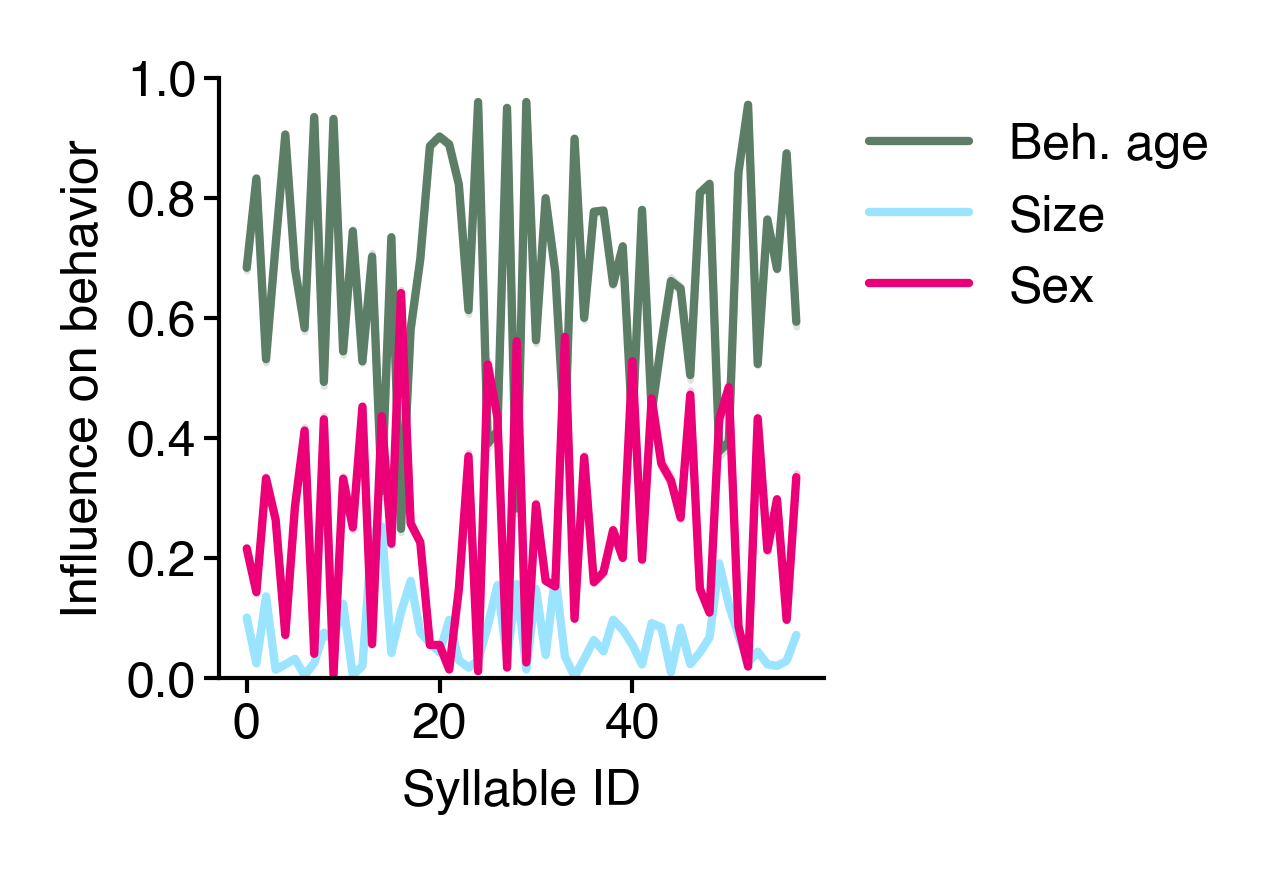

In [38]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(data=plt_dfs, x='syllable', y='influence', errorbar='se', hue='type', palette=cc.glasbey[24:27])
ax.set(xlabel="Syllable ID", ylabel="Influence on behavior", ylim=(0, 1))
legend()
sns.despine()
saver(fig, 'sex-syllables-component-influence-on-behavior');

In [39]:
x = pd.pivot_table(
    plt_dfs.groupby(["syllable", "type"])["influence"].mean().reset_index(),
    index="syllable",
    columns="type",
    values="influence",
)
remapping = dict(
    map(reversed, enumerate(x.sort_values(by="Beh. age", ascending=False).index))
)

In [40]:
plt_dfs.head()

mouse  age   bio_age  sex syllable  influence      type bio_bin age_bin
0  4M_01_01    4  4.942997    0        0   0.951990  Beh. age  5.0735   5.296
1  4M_01_02    4  4.623334    0        0   0.964587  Beh. age  5.0735   5.296
2  4M_01_03    4  4.202199    0        0   0.960621  Beh. age  5.0735   5.296
3  4M_01_04    4  3.993509    0        0   0.959161  Beh. age  5.0735   5.296
4  4M_02_01    4  3.930444    0        0   0.975172  Beh. age  5.0735   5.296

In [41]:
plt_dfs['sorted_syllable'] = plt_dfs['syllable'].map(remapping)

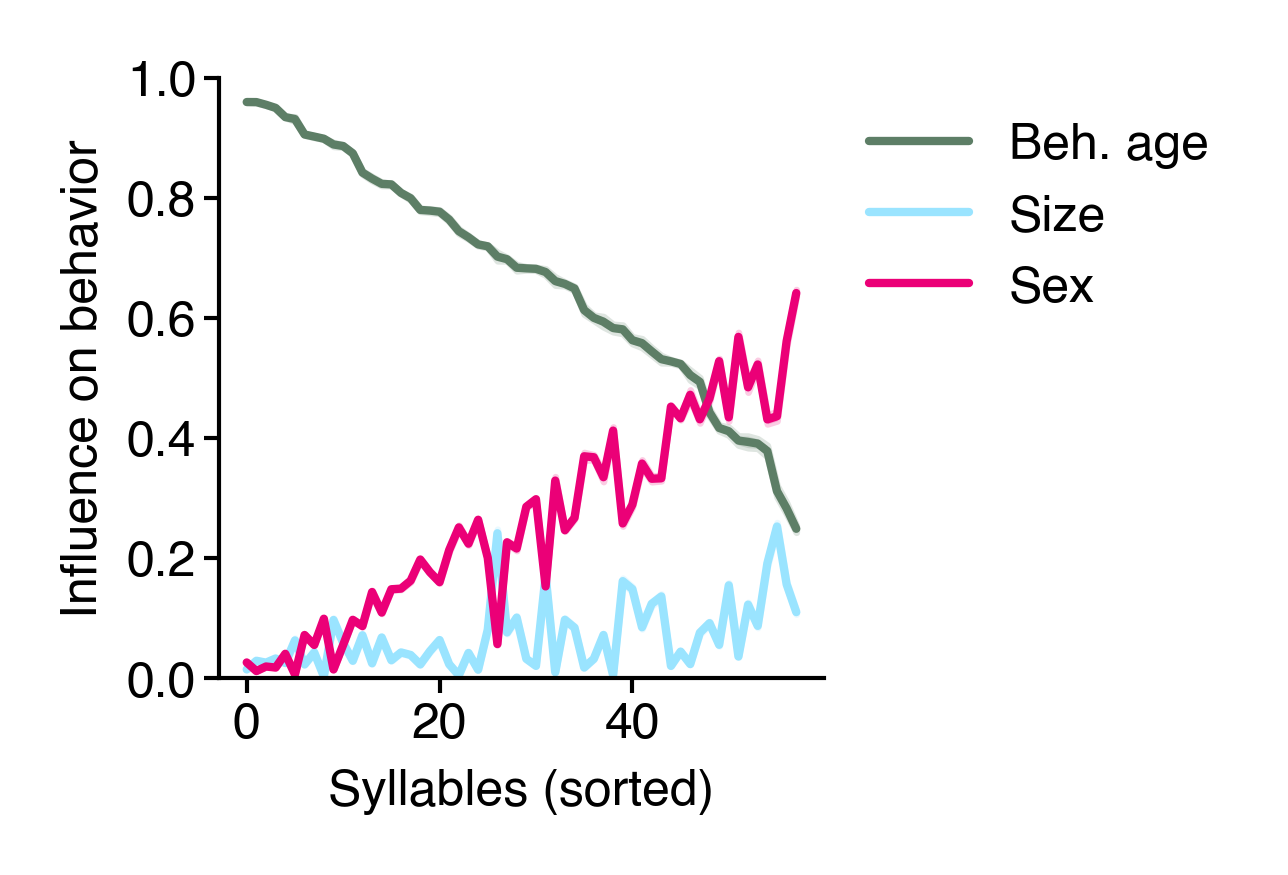

In [42]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(data=plt_dfs, x='sorted_syllable', y='influence', errorbar='se', hue='type', palette=cc.glasbey[24:27])
ax.set(xlabel="Syllables (sorted)", ylabel="Influence on behavior", ylim=(0, 1))
legend()
sns.despine()
saver(fig, 'sex-syllables-component-influence-on-behavior-sorted');

In [43]:
# rank-order influences
tmp = plt_dfs.groupby(['syllable', 'type'])[['influence']].mean()
ranks = tmp.groupby('type').rank().reset_index()

In [44]:
mp = ranks.query('type == "Sex"').set_index('syllable')['influence']

In [45]:
ranks['color'] = ranks['syllable'].map(mp)

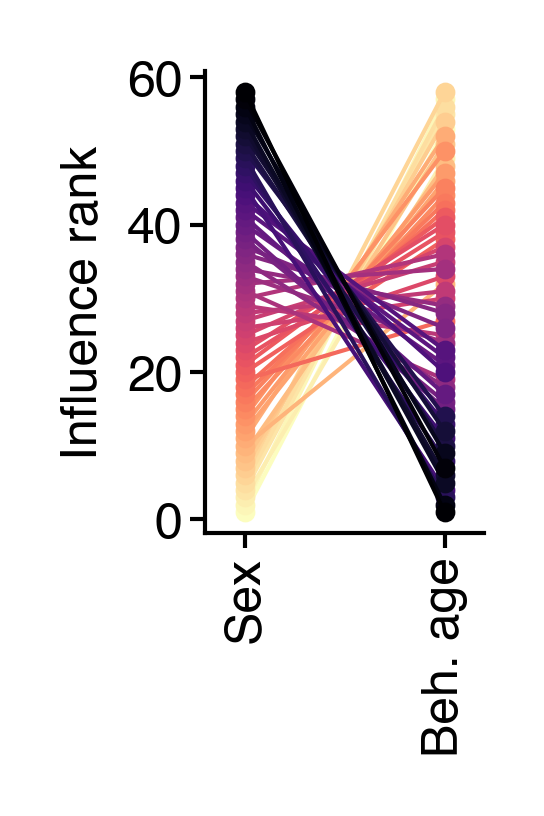

In [46]:
# NOTE: I don't think this plot is useful any more - this is a necessary outcome of looking at relative influence
fig = figure(0.6, 1)
ax = sns.pointplot(
    data=ranks,
    x="type",
    y="influence",
    hue="color",
    palette="magma_r",
    order=["Sex", "Beh. age"],
    legend=False,
    markersize=2,
    linewidth=0.5
)
ax.set(xlabel="", xlim=(-0.2, 1.2), ylabel="Influence rank")
plt.xticks(rotation=90)
sns.despine()
# saver(fig, "sex-rank-order-influence");

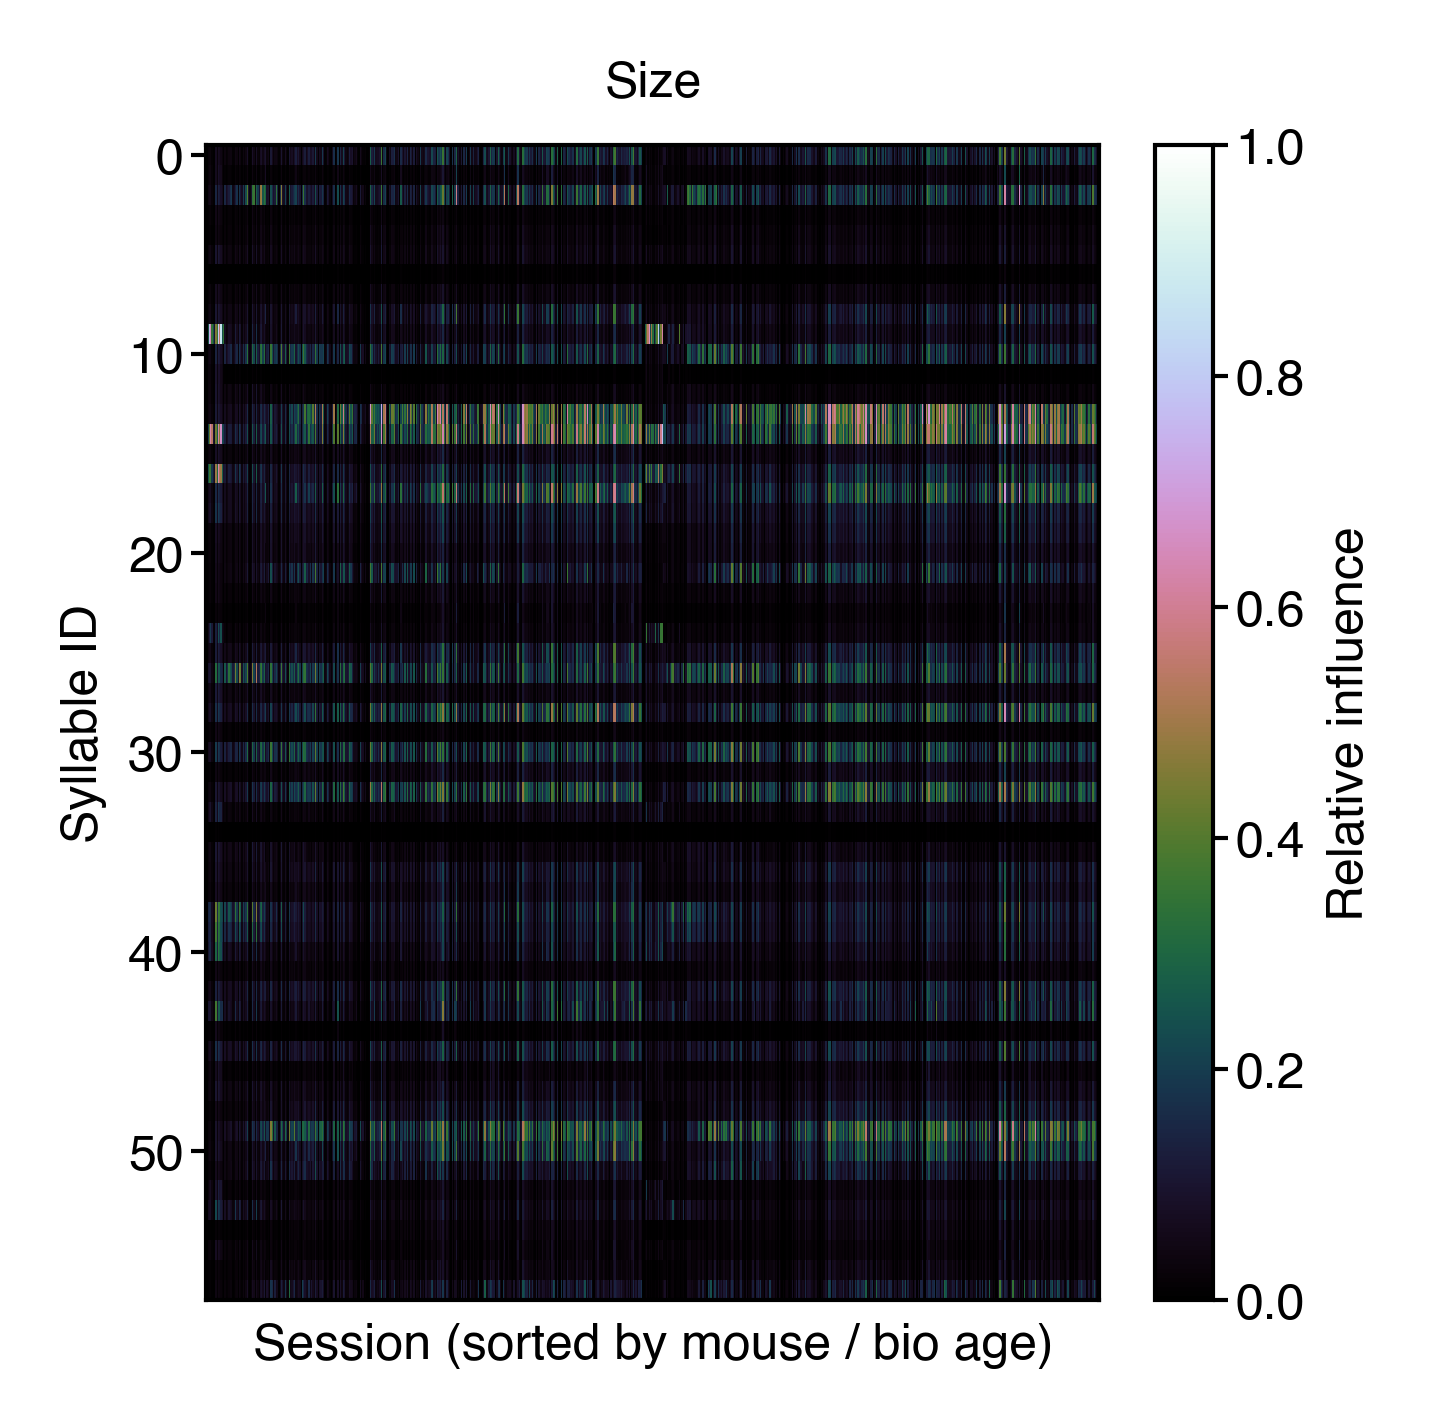

In [47]:
fig = figure(2.4, 2.5)
plt.imshow(size, aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='cubehelix')
plt.colorbar(label="Relative influence")
plt.xticks([])
plt.ylabel("Syllable ID")
plt.title("Size")
plt.xlabel("Session (sorted by mouse / bio age)")
saver(fig, "sex-size-influence-matrix");

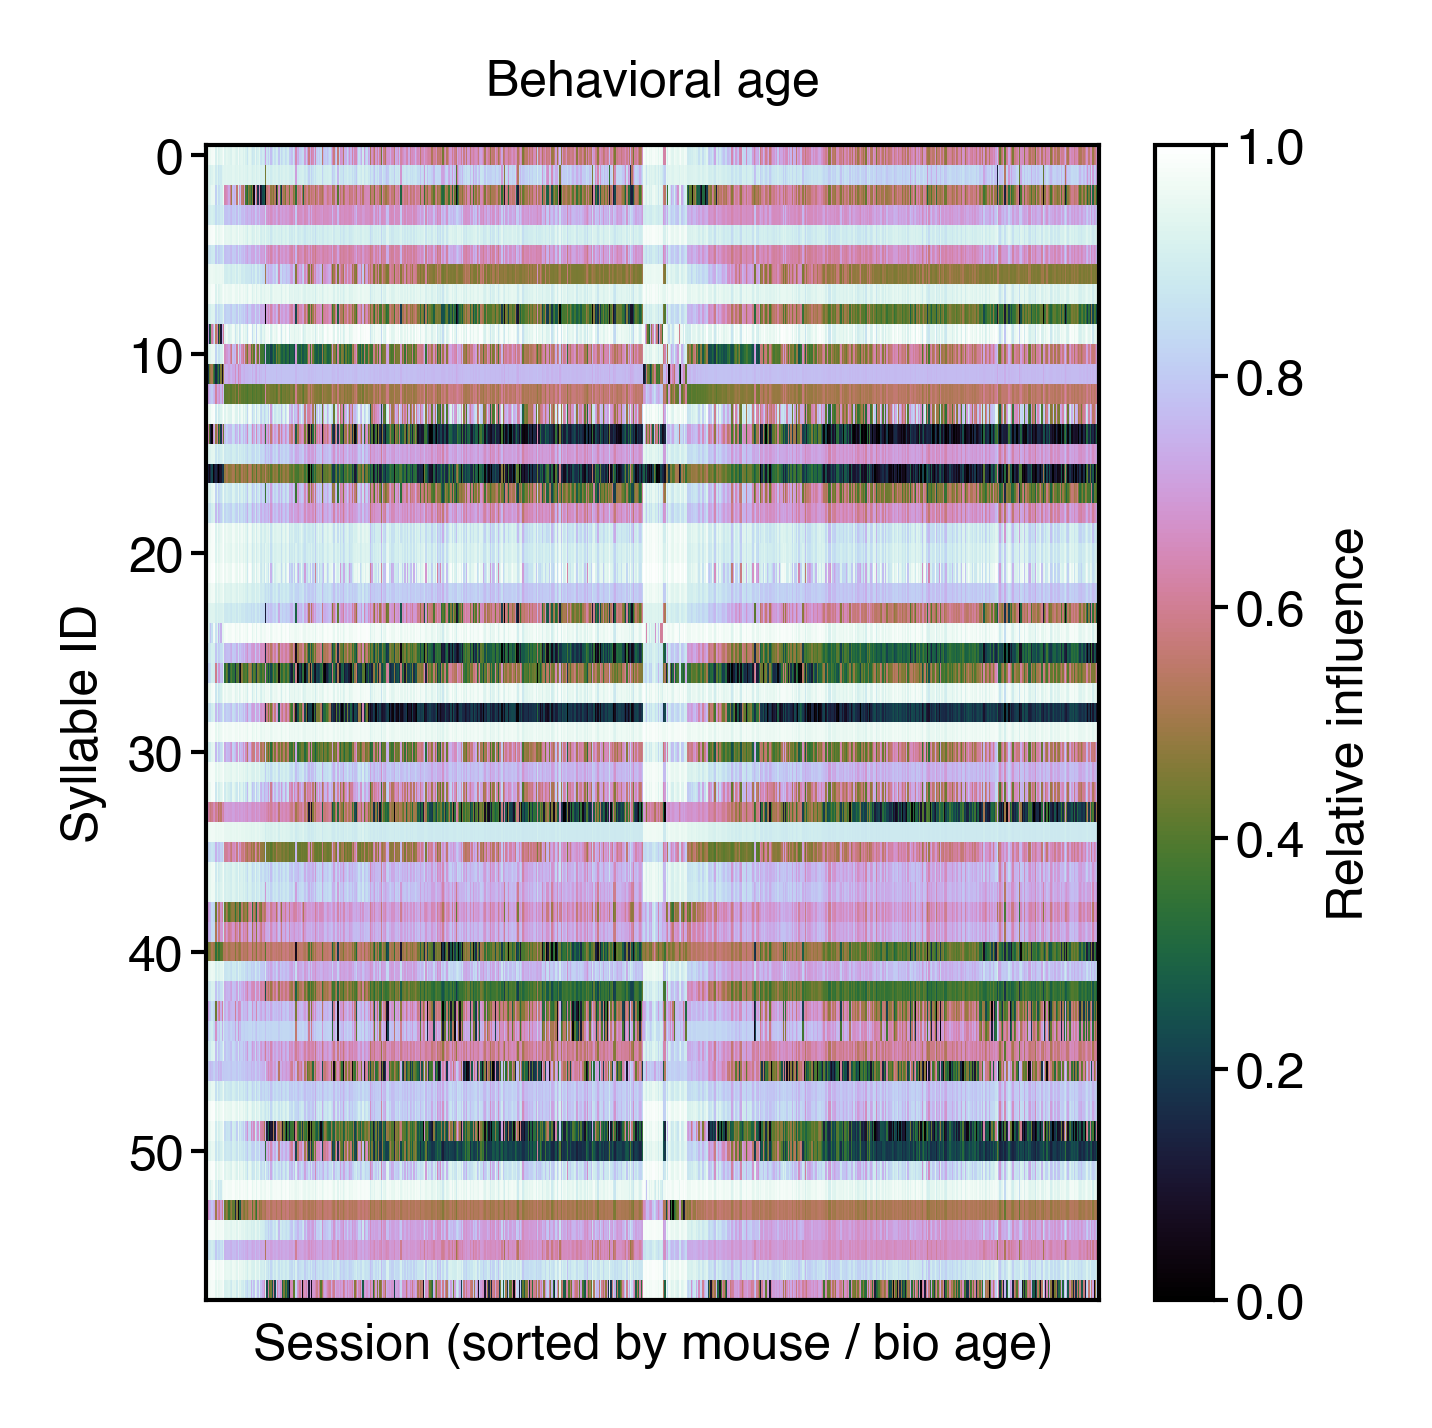

In [48]:
fig = figure(2.4, 2.5)
plt.imshow(bio, aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='cubehelix')
plt.colorbar(label="Relative influence")
plt.xticks([])
plt.ylabel("Syllable ID")
plt.title("Behavioral age")
plt.xlabel("Session (sorted by mouse / bio age)")
saver(fig, "sex-beh-age-influence-matrix");

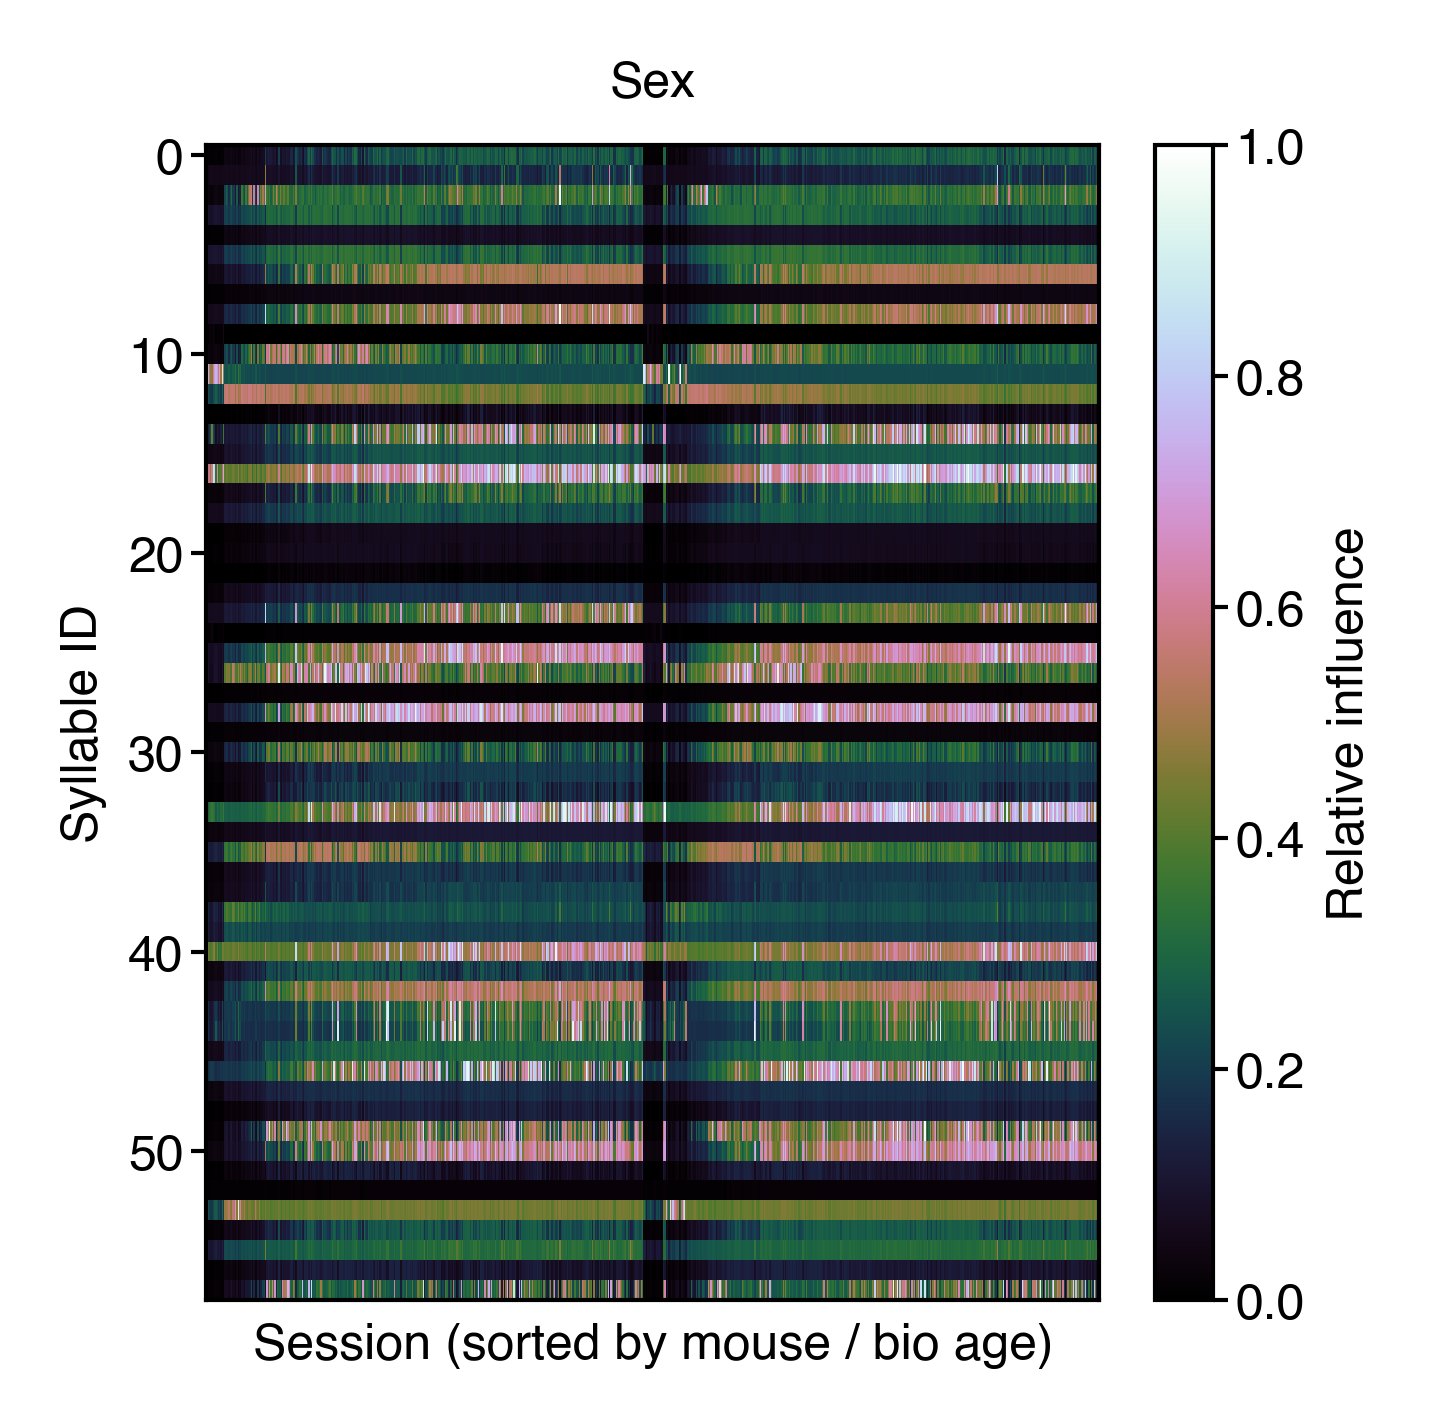

In [49]:
fig = figure(2.4, 2.5)
plt.imshow(indiv, aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='cubehelix')
plt.colorbar(label="Relative influence")
plt.xticks([])
plt.ylabel("Syllable ID")
plt.title("Sex")
plt.xlabel("Session (sorted by mouse / bio age)")
saver(fig, "sex-indiv-influence-matrix");

## NMF on just males??

In [50]:
from sklearn.decomposition import NMF

In [51]:
def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

### Males

In [52]:
males = df.query('sex == 0')
mask = df.index.get_level_values('sex') == 0

age_np = pd.Series(np.array(males.index.get_level_values('age')))
bio_age_map = pd.qcut(mdl['bio_ages'][mask], len(np.unique(age_np)), labels=False)

nmf = NMF(n_components=4, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(minmax(males))
bam = pd.Series(mdl['bio_ages'][mask]).groupby(bio_age_map).mean()

nmf_scores_df = pd.DataFrame(scores, males.index)
nmf_scores_df['bio_age'] = pd.Series(bio_age_map).map(bam).to_numpy()
nmf_scores_df = nmf_scores_df.set_index('bio_age', append=True)

In [53]:
cmap = COLORMAPS.ont_male(np.linspace(0, 1, 4))

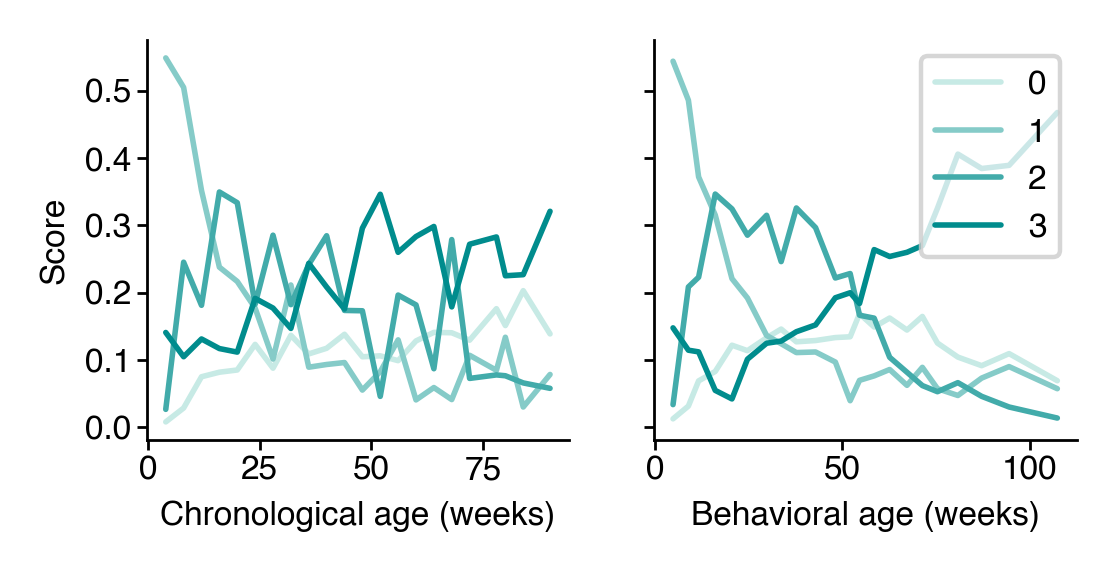

In [54]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cmap)}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True)
    a = nmf_scores_df.groupby('age').mean().plot(ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Score")
    a2 = nmf_scores_df.groupby('bio_age').mean().plot(ax=ax[1])
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Score")
    sns.despine()
    saver(fig, "nmf-components-pre-post-sorting-blue-colors");

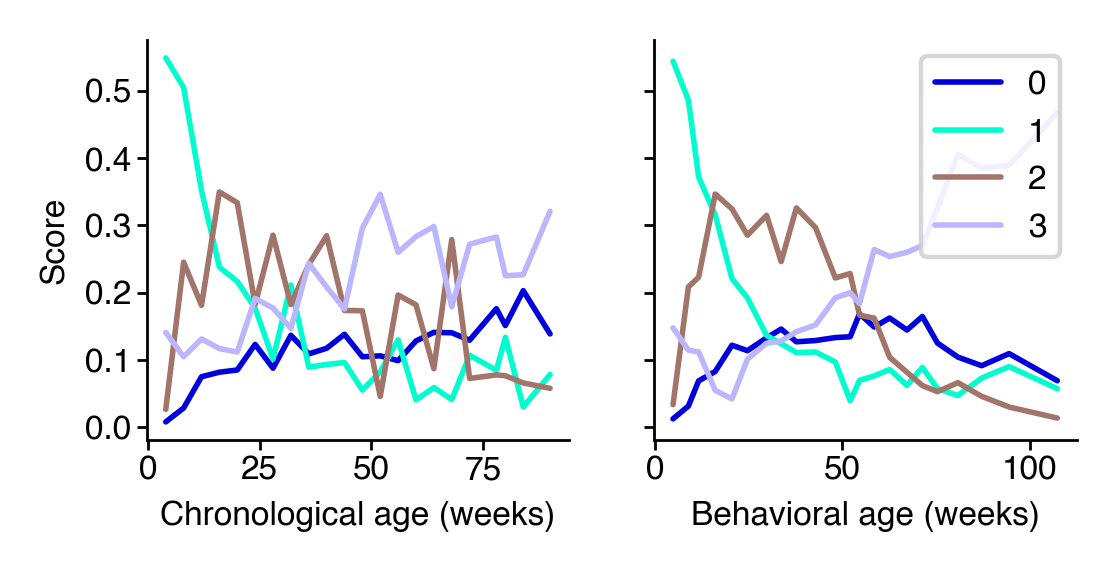

In [55]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey[10:])}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True)
    a = nmf_scores_df.groupby('age').mean().plot(ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Score")
    a2 = nmf_scores_df.groupby('bio_age').mean().plot(ax=ax[1])
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Score")
    sns.despine()
    saver(fig, "nmf-components-pre-post-sorting");

### Females

In [56]:
females = df.query('sex == 1')
mask = df.index.get_level_values('sex') == 1

age_np = pd.Series(np.array(males.index.get_level_values('age')))
bio_age_map = pd.qcut(mdl['bio_ages'][mask], len(np.unique(age_np)), labels=False)

nmf = NMF(n_components=4, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(minmax(females))
bam = pd.Series(mdl['bio_ages'][mask]).groupby(bio_age_map).mean()

nmf_scores_df = pd.DataFrame(scores, females.index)
nmf_scores_df['bio_age'] = pd.Series(bio_age_map).map(bam).to_numpy()
nmf_scores_df = nmf_scores_df.set_index('bio_age', append=True)

In [57]:
cmap = COLORMAPS.ont_female(np.linspace(0, 1, 4))

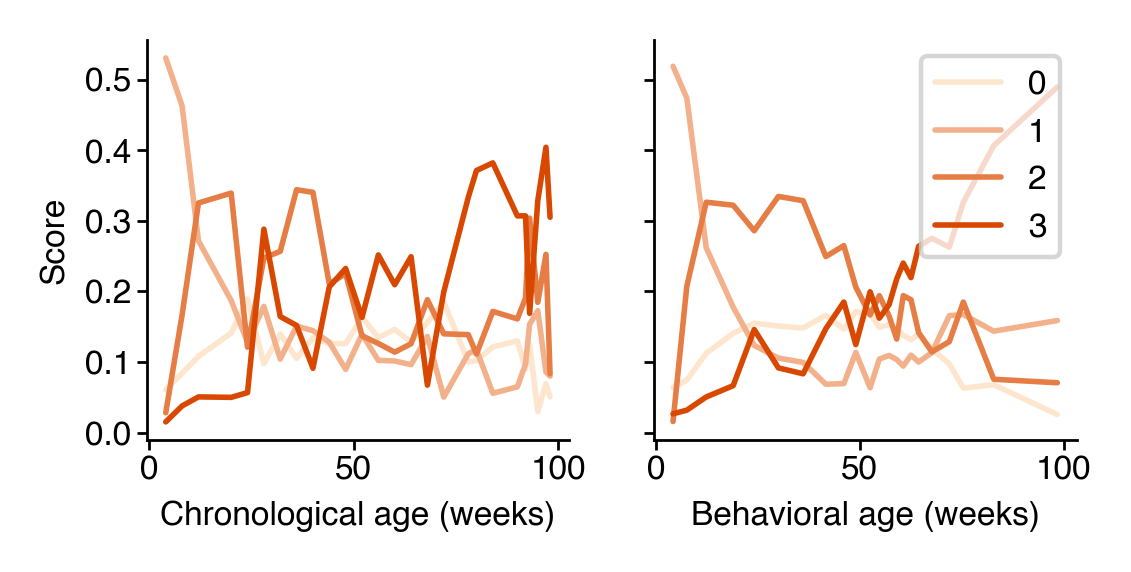

In [58]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cmap)}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True)
    a = nmf_scores_df.groupby('age').mean().plot(ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Score")
    a2 = nmf_scores_df.groupby('bio_age').mean().plot(ax=ax[1])
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Score")
    sns.despine()
    saver(fig, "female-nmf-components-pre-post-sorting-orange-colors");

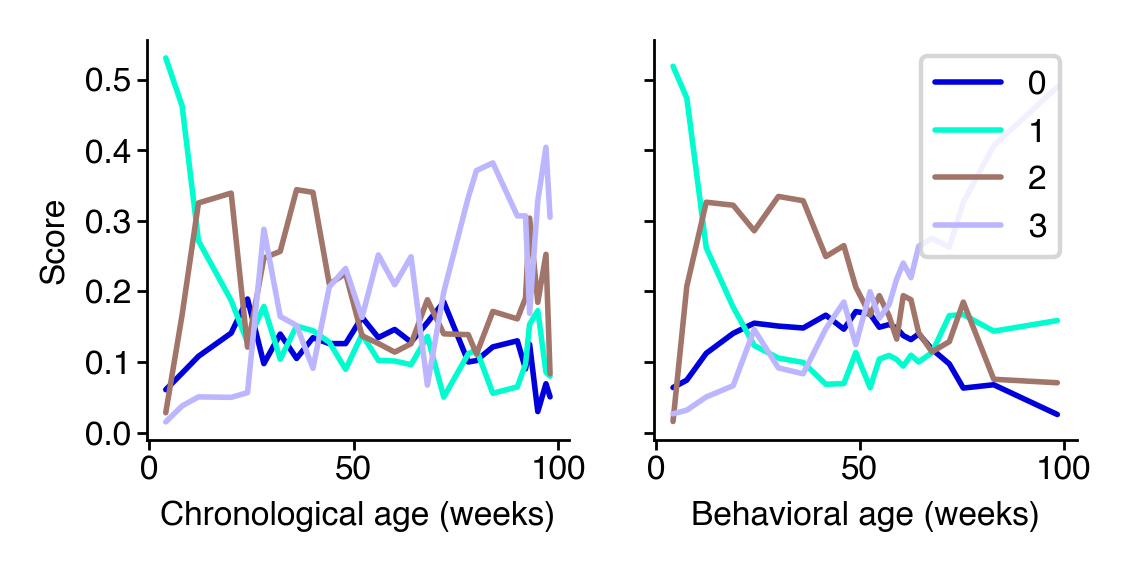

In [59]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey[10:])}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True)
    a = nmf_scores_df.groupby('age').mean().plot(ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Score")
    a2 = nmf_scores_df.groupby('bio_age').mean().plot(ax=ax[1])
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Score")
    sns.despine()
    saver(fig, "female-nmf-components-pre-post-sorting");

## K-means

In [60]:
from sklearn.cluster import k_means

In [61]:
n_clusters = 4

In [ ]:
males = df.query('sex == 0')
mask = df.index.get_level_values('sex') == 0

age_np = pd.Series(np.array(males.index.get_level_values('age')))
bio_age_map = pd.qcut(mdl['bio_ages'][mask], len(np.unique(age_np)), labels=False)

centroid, labels, inertia = k_means(minmax(males).T, n_clusters, random_state=0)
bam = pd.Series(mdl['bio_ages'][mask]).groupby(bio_age_map).mean()

syllable_coef_map = pd.DataFrame(dict(zip(df.columns, labels)), index=['component']).T
syllable_coef_map.index.name = "syllable"
syllable_coef_map = syllable_coef_map.reset_index()

component_sylls = syllable_coef_map.groupby('component')['syllable'].unique()

mm_df = minmax(males)
mm_df['bio_age'] = pd.Series(bio_age_map).map(bam).to_numpy()
mm_df = mm_df.set_index('bio_age', append=True)

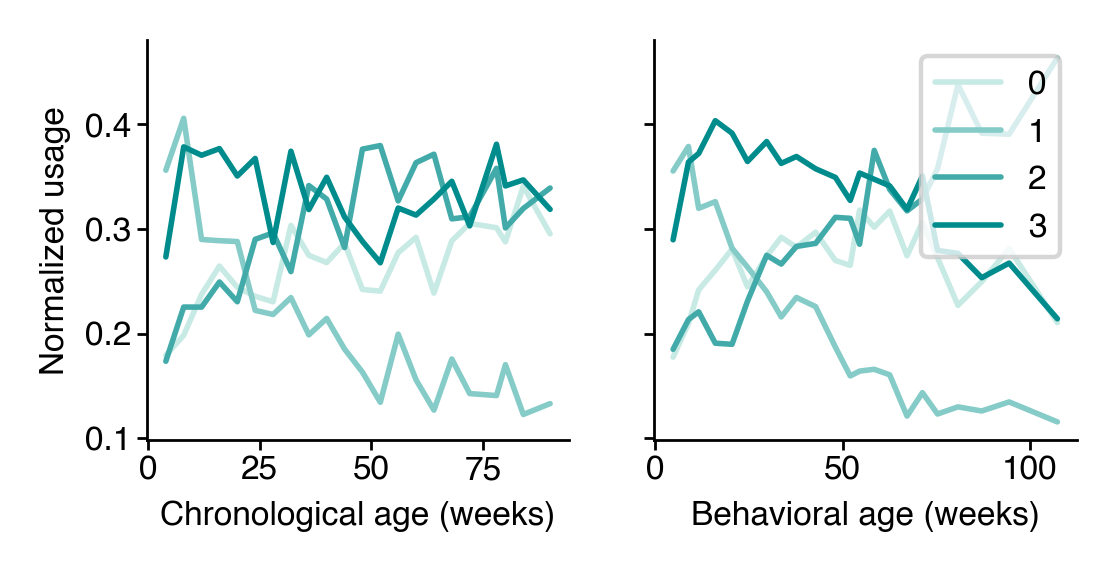

In [82]:
cmap = COLORMAPS.ont_male(np.linspace(0, 1, 4))

with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cmap)}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True)
    for i in range(n_clusters):
        a = mm_df[component_sylls.loc[i]].groupby('age').mean().mean(1).plot(label=i, ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Normalized usage")
    for i in range(n_clusters):
        a2 = mm_df[component_sylls.loc[i]].groupby('bio_age').mean().mean(1).plot(label=i, ax=ax[1], legend=True)
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Normalized usage")
    sns.despine()
    saver(fig, "k-means-pre-post-sorting-blue-colors");

### Females

In [83]:
females = df.query('sex == 1')
mask = df.index.get_level_values('sex') == 1

age_np = pd.Series(np.array(females.index.get_level_values('age')))
bio_age_map = pd.qcut(mdl['bio_ages'][mask], len(np.unique(age_np)), labels=False)

centroid, labels, inertia = k_means(minmax(females).T, n_clusters, random_state=0)
bam = pd.Series(mdl['bio_ages'][mask]).groupby(bio_age_map).mean()

syllable_coef_map = pd.DataFrame(dict(zip(df.columns, labels)), index=['component']).T
syllable_coef_map.index.name = "syllable"
syllable_coef_map = syllable_coef_map.reset_index()

component_sylls = syllable_coef_map.groupby('component')['syllable'].unique()

mm_df = minmax(females)
mm_df['bio_age'] = pd.Series(bio_age_map).map(bam).to_numpy()
mm_df = mm_df.set_index('bio_age', append=True)

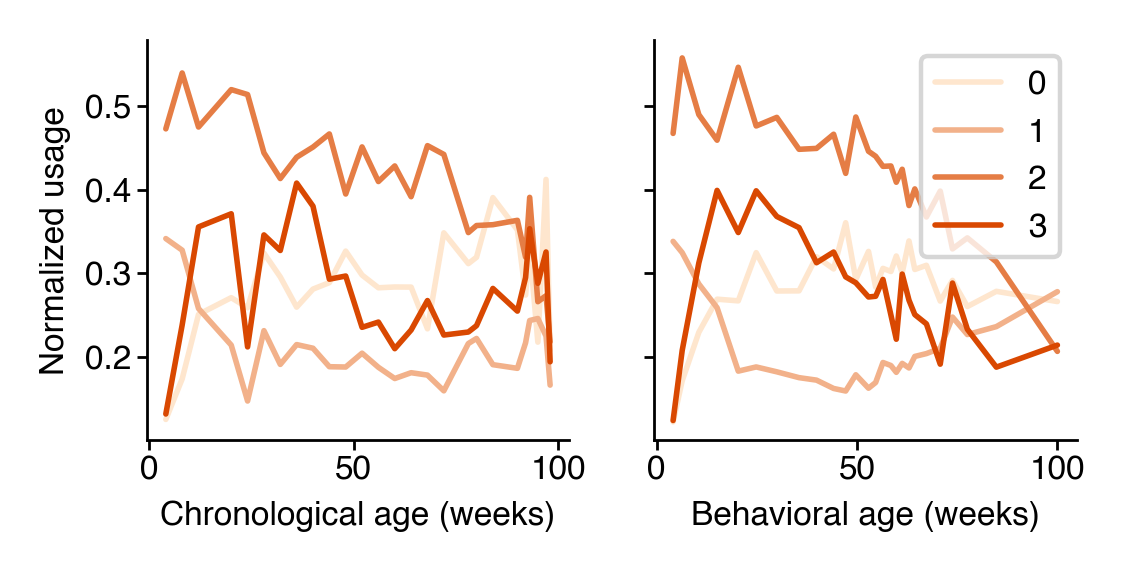

In [84]:
cmap = COLORMAPS.ont_female(np.linspace(0, 1, 4))

with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cmap)}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True)
    for i in range(n_clusters):
        a = mm_df[component_sylls.loc[i]].groupby('age').mean().mean(1).plot(label=i, ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Normalized usage")
    for i in range(n_clusters):
        a2 = mm_df[component_sylls.loc[i]].groupby('bio_age').mean().mean(1).plot(label=i, ax=ax[1], legend=True)
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Normalized usage")
    sns.despine()
    saver(fig, "female-k-means-pre-post-sorting-blue-colors");